## 过程：

1. 读入智联招聘关于软件/互联网开发/系统集成方面的招聘数据（ zlzp_position.csv ）； 
&emsp;&emsp;或者：爬取https://sou.zhaopin.com/jobs/searchresult.ashx?bj=160000&jl=北京&p=1 网页上的招聘信息，每条信息包含以下字段：月薪（若为区间值，则取该区间的均值，月薪为“面议”的样本将其舍去）、工作经验、招聘人数、最低学历、是否有五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权，并保存为csv文件； 
2. 把五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权看作公司福利，请对各种类型公司提供的福利多少分别进行降序排序，并打印输出；   <font color='red'>分值：5</font>
3. 对不同最低学历要求的月薪分布绘制直方图，对其均值绘制柱状图；对不同最低学历要求的招聘人数绘制饼图；    
4. 以月薪为因变量，以其他特征为自变量（特征自选），建立特征对月薪的预测模型。要求至少选择两种机器学习算法，从中选择较优的算法并确定最优超参数（如果算法有超参数） 。  

# 一、任务一

<font size=3>**要求1： 进入https://sou.zhaopin.com/jobs/searchresult.ashx?bj=160000&jl=北京&p=1 爬取所有分类下的所有招聘信息。**</font>

**需要读取：** 

每页的招聘链接：<img src="img/招聘信息.jpg" width="30%">
页面最下方的页码链接以转到下一页:<img src="img/页码.jpg" width="30%">
页面最上方的“职位类别”链接:<img src="img/职位类别.jpg" width="30%">
     
<font size=3>**要求2：获取每个招聘信息的链接之后,详细解析具体的每一个招聘页面**</font>

**需要读取：**

岗位名称、公司名称、是否有五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权：<img src="img/公司信息.jpg" width="30%">
公司类型：<img src="img/公司类型.jpg" width="10%">
月薪、工作经验、招聘人数、最低学历：<img src="img/招聘具体信息.jpg" width="30%">

## 具体过程

**建立爬虫目录如下：**
<img src="img/爬虫目录.jpg" width="20%">
**下面是详细文件：**

### 1. items.py

``` python
import scrapy
class ZlzpItem(scrapy.Item):
    # define the fields for your item here like:
    jobName=scrapy.Field()#岗位名称
    companyName=scrapy.Field()#公司名称
    companyProp=scrapy.Field()#公司类型
    salary=scrapy.Field()#月薪
    workExperience=scrapy.Field()#工作经验
    recruitmentNumber=scrapy.Field()#招聘人数
    education=scrapy.Field()#最低学历
   #福利：五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权
    fuli=scrapy.Field()
    pass  
```
### 2. zlzp.py


``` python
import scrapy
import re #正则匹配
from ZLZP.items import ZlzpItem

#爬取数据，再在pipelines里处理数据
class ZlzpSpider(scrapy.Spider):
    name = 'zlzp'
    #allowed_domains = ['http://news.bnu.edu.cn']#不注释的话 会爬不了
    page=1#从第一页开始爬
    front_urls='https://sou.zhaopin.com/jobs/searchresult.ashx?bj=160000&jl=%E5%8C%97%E4%BA%AC&p='
    page_urls=front_urls+str(page)
    start_urls = [page_urls]#最初始的url
    def parse(self,response):
        #爬取各个类型的招聘信息的链接
        i=-1
        for type in response.xpath("//*[@id='search_jobtype_tag']/a"):
            i+=1
            if i==0:
                continue#跳过第一个“不限”
            type_url="https://sou.zhaopin.com/"+type.xpath("@href").extract_first()
            #print("*****************",type_url)
            yield  scrapy.Request(type_url,callback=self.parse_each_page)
    def parse_each_page(self, response):
        #pass
        #爬取每一种类别下的每一页招聘信息
        i=-1#用来排除表头
        for work in response.xpath("//*[@id='newlist_list_content_table']/table"):#获取除表头外的所有招聘链接
            i += 1
            if i==0:
                continue#跳过表头
            url=work.xpath('tr[1]/td[1]/div/a[1]/@href').extract_first()#获取岗位链接
            #print("################",url)
            yield scrapy.Request(url,callback=self.parse_dir_details)
            #使用scrapy.Request用以返回爬取的某条招聘信息的链接，再用callback函数对返回链接进行再次爬取从而获取招聘信息具体内容，将爬取数据处理给item
        #取下一页的
        next_page=response.xpath("//*[@class='pagesDown-pos']/a/@href").extract_first()
        yield  scrapy.Request(next_page,callback=self.parse_each_page)

    def parse_dir_details(self,response):#用来爬取某个招聘链接里的具体内容
        item=ZlzpItem()
        item['jobName'] =response.xpath("//div[@class='top-fixed-box']/div[1]/div[1]/h1/text()") .extract_first() # 岗位名称
        item['companyName'] =response.xpath("//div[@class='top-fixed-box']/div[1]/div[1]/h2/a/text()").extract_first()   # 公司名称
        item['companyProp']=response.xpath("//div[@class='company-box']/ul/li[2]/strong/text()").extract_first().replace(u'\xa0',u' ') #公司类型
        #五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权
        #提取公司福利
        all_fuli=response.xpath("/html/body/div[5]/div[1]/div[1]/div[1]/span/text()").extract()
        #因为每个岗位可能有多个福利，就讲匹配到的内容用extract（）,就会返回一个列表，里面是提取到的所有福利的text
        #用一个7位的数组表示是否有这七个福利，有则将对应位置为1
        item['fuli']=[int(a_fuli in all_fuli) for a_fuli in ("五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权".split("\\"))]
        job_detail_path=response.xpath("//div[@class='terminalpage-left']/ul")
        item['salary'] =sum(float(i) for i in re.findall("\d+",job_detail_path.xpath("li[1]/strong/text()").extract_first().replace(u'\xa0',u' ')))/2   # 月薪
        item['workExperience'] =job_detail_path.xpath("li[5]/strong/text()").extract_first().replace(u'\xa0',u' ')   # 工作经验
        item['recruitmentNumber'] =job_detail_path.xpath("li[7]/strong/text()").extract_first().replace(u'\xa0',u' ')   # 招聘人数
        item['education'] =job_detail_path.xpath("li[6]/strong/text()").extract_first().replace(u'\xa0',u' ')   # 最低学历
        yield  item
```
### 3. pipelines
``` python
import csv

class ZlzpPipeline(object):
    def __init__(self):
        self.f = open('result.csv','w',newline='')
        self.headers = ['jobName','companyName','companyProp','salary','workExperience','recruitmentNumber','education',
                   '五险一金','带薪休假','员工旅游','周末双休','弹性工作','餐补','交通补助','年底双薪','股票期权']
        self.writer = csv.writer(self.f)
        self.writer.writerow(self.headers)
    def process_item(self,item,spider):
        arow=[]
        for i in self.headers[:7]:
            arow.append(item[i])
        for i in item['fuli']:
            arow.append(i)
        self.writer.writerow(arow)
        return item
    def close_spider(self, spider):
        self.f.close()
```

最后爬出到的csv文件如下：

In [2]:
import pandas as pd
#任务1
#读取存有所有招聘信息的csv文件
job_list_csv=pd.read_csv('result.csv')
job_list_csv

,jobName,companyName,companyProp,salary,workExperience,recruitmentNumber,education,五险一金,带薪休假,员工旅游,周末双休,弹性工作,餐补,交通补助,年底双薪,股票期权
0,高级前端开发工程师,厦门千时科技有限公司,民营,36000.0,5-10年,5人,本科,1,0,1,1,1,0,0,0,0
1,大数据开发工程师,北京恒昌利通投资管理有限公司,民营,0.0,3-5年,3人,本科,1,0,0,0,0,1,0,0,0
2,PHP开发工程师,北京轻松筹网络科技有限公司,民营,12500.5,3-5年,1人,本科,1,0,0,0,1,0,0,1,0
3,PHP开发工程师（北京）,深圳市八斗才数据有限公司,民营,12500.5,1-3年,2人,大专,1,0,1,0,1,0,0,0,0
4,数据研发工程师,北京恒昌利通投资管理有限公司,民营,0.0,3-5年,2人,本科,1,0,0,0,0,1,0,0,0
5,PHP开发工程师,领途教育咨询(北京)有限公司,其它,11500.0,1-3年,2人,本科,1,0,0,1,1,0,0,0,1
6,技术经理（互联网）,信广金融服务外包(北京)有限公司,民营,22500.0,5-10年,1人,本科,1,0,1,1,1,0,0,0,0
7,安卓工程师,北京尧米科技有限公司,民营,17500.5,3-5年,1人,本科,1,0,0,1,1,0,0,1,1
8,搜索开发工程师,北京因果树网络科技有限公司,股份制企业,25000.5,3-5年,1人,本科,0,0,0,0,0,0,0,0,0
9,windows C++工程师,北京华睿科创科技有限公司,股份制企业,15000.0,5-10年,1人,本科,1,0,0,1,1,0,0,0,0


# 二、任务二

In [4]:
#任务2
#把五险一金\带薪休假\员工旅游\周末双休\弹性工作\餐补\交通补助\年底双薪\股票期权看作公司福利，
#请对各种类型公司提供的福利多少分别进行降序排序
job_list = job_list_csv
fuli=job_list.columns[10:18]#提取表头中的各项具体福利
job_comp= job_list.groupby('companyProp')
comp_fuli=job_comp[fuli].sum()
for gs in comp_fuli.index:
    print(comp_fuli.loc[gs].sort_values(ascending=False))
    print("*******************************")

餐补      1733
周末双休     893
弹性工作     878
年底双薪     772
交通补助     692
股票期权     283
Name: 上市公司, dtype: int64
*******************************
餐补      139
交通补助     73
周末双休     41
年底双薪     29
弹性工作      5
股票期权      0
Name: 事业单位, dtype: int64
*******************************
年底双薪    4
交通补助    4
餐补      1
周末双休    1
股票期权    0
弹性工作    0
Name: 代表处, dtype: int64
*******************************
周末双休    192
餐补      155
弹性工作    135
年底双薪     77
交通补助     74
股票期权     73
Name: 保密, dtype: int64
*******************************
餐补      434
弹性工作    316
周末双休    295
交通补助    233
年底双薪    217
股票期权     81
Name: 其它, dtype: int64
*******************************
餐补      2
股票期权    0
年底双薪    0
交通补助    0
弹性工作    0
周末双休    0
Name: 医院, dtype: int64
*******************************
餐补      663
周末双休    653
弹性工作    629
交通补助    390
年底双薪    386
股票期权     98
Name: 合资, dtype: int64
*******************************
餐补      1407
交通补助     892
周末双休     544
年底双薪     377
弹性工作     341
股票期权      55
Name: 国企, dtype: int64
***********************

# 三、任务三

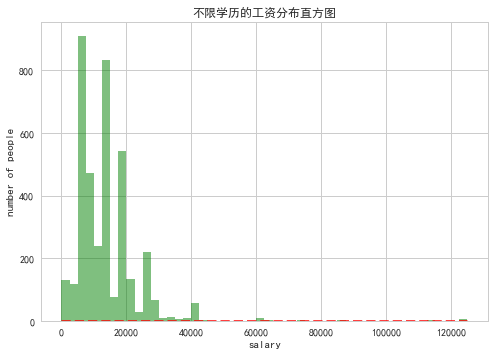

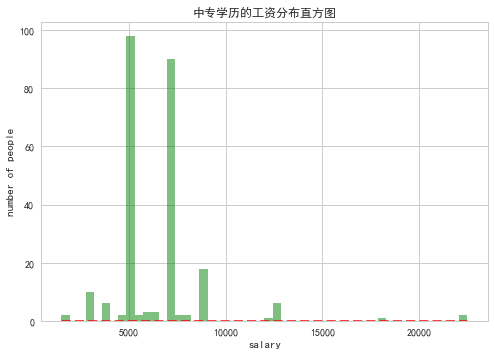

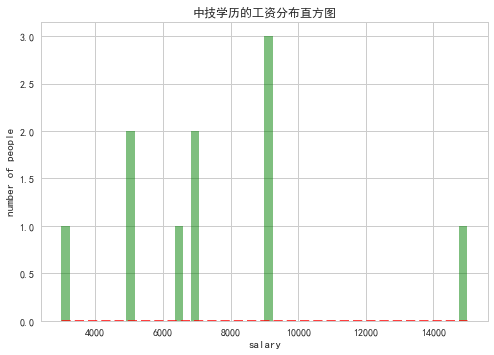

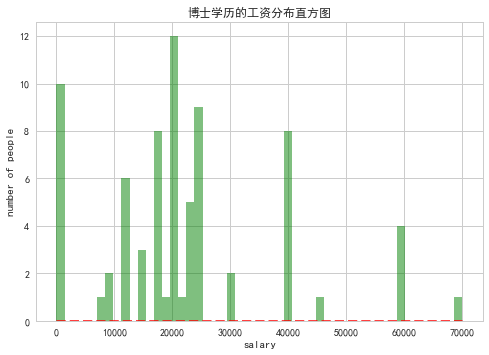

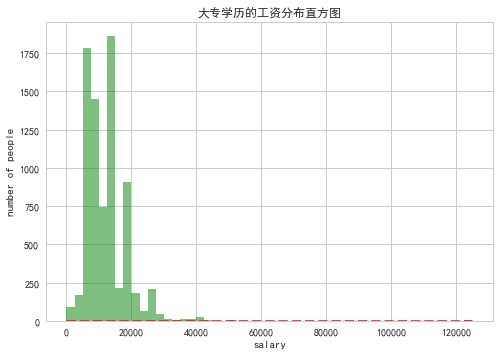

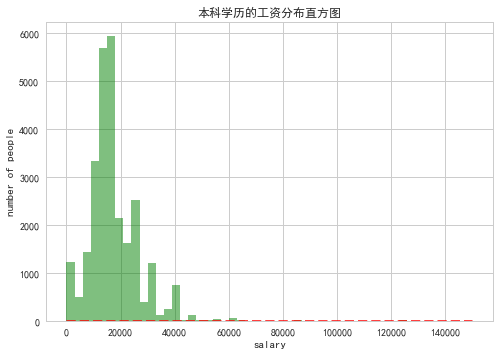

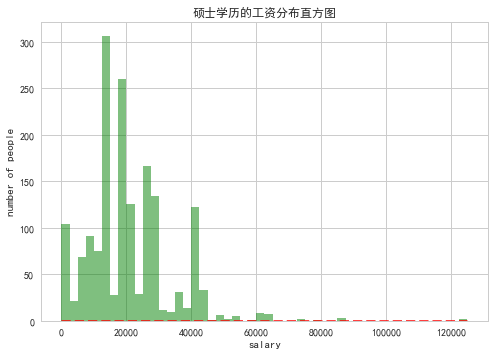

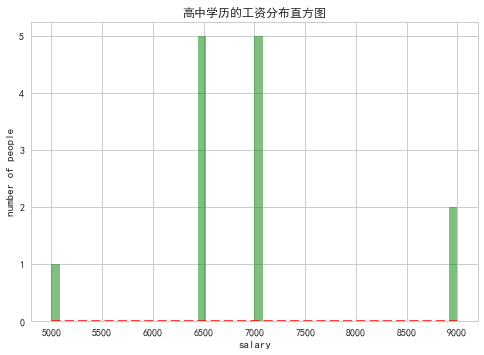

In [5]:
#任务3
#对不同最低学历要求的月薪分布绘制直方图，
#对其均值绘制柱状图；
#对不同最低学历要求的招聘总人数绘制饼图
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

job_edu=job_list.groupby('education')
#绘制学历与所有工资的直方图
for edu,group in job_edu:#各种学历
    n,bins,patches=plt.hist(job_edu['salary'].get_group(edu),bins=50,facecolor='green',alpha=0.5)
    y=mlab.normpdf(bins,100,15)
    plt.plot(bins,y,'r--',linewidth=2.5)
    plt.xlabel("salary")
    plt.ylabel("number of people")
    plt.title(edu+'学历的工资分布直方图')
    plt.show()

D:\software\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


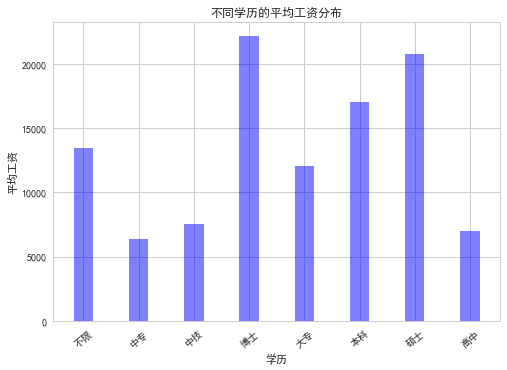

In [6]:
#绘制学历与平均工资的柱状图
edu_salary_m=job_edu['salary'].mean()
edu=edu_salary_m.index
xlen=range(len(edu))
plt.bar(xlen,edu_salary_m,0.35,alpha=0.5,color='b')
plt.xlabel('学历')
plt.ylabel('平均工资')
plt.title('不同学历的平均工资分布')
plt.xticks(xlen,edu,rotation=40)
plt.legend()
plt.show()

education
不限     3889
中专      248
中技       10
博士       74
大专     7802
本科    27407
硕士     1667
高中       13
Name: recruitmentNumber, dtype: int64


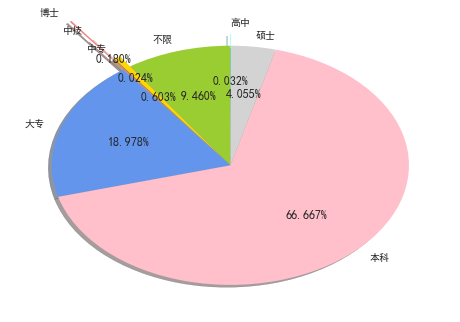

In [7]:
#绘制对不同最低学历要求的招聘总人数饼图
#job_e=job_edu['recruitmentNumber']+'1'
#job_e=numpy.mean(float(i) for i in re.findall("\d+",job_edu['recruitmentNumber']))
#print(job_e)
edu_num=job_edu['recruitmentNumber'].count()
print(edu_num)
explode=[0,0.1,0.3,0.5,0,0,0,0.1]
colors=['yellowgreen','gold','darkred','lightcoral','cornflowerblue','pink','lightgray','cyan']
plt.pie(edu_num,explode=explode,labels=edu_num.index,colors=colors,shadow=True,autopct='%1.3f%%',startangle=90)
plt.show()

# 四、任务四

**主要方法：使用sgd回归和k近邻两种方法建立“工作经验”、“最低学历”和“公司类型”对月薪的预测**

### 1. 特征选择

In [8]:
#建立其他特征对月薪的预测模型，至少选择两种机器学习算法
#从中选择较优的算法并确定最优超参数
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split  # ShuffleSplit
featureList=job_list.loc[:,['workExperience','education','companyProp']]
labelList=job_list.loc[:,'salary']
featureList

,workExperience,education,companyProp
0,5-10年,本科,民营
1,3-5年,本科,民营
2,3-5年,本科,民营
3,1-3年,大专,民营
4,3-5年,本科,民营
5,1-3年,本科,其它
6,5-10年,本科,民营
7,3-5年,本科,民营
8,3-5年,本科,股份制企业
9,5-10年,本科,股份制企业


### 2.建立训练集和测试集

In [9]:
from sklearn.preprocessing import StandardScaler

#将原始数据转换成矩阵数据
vec=DictVectorizer()
dummyX=vec.fit_transform(featureList.to_dict(orient='record')).toarray()#将参考的列转化为数组
X_train, X_test, y_train, y_test = train_test_split(dummyX, labelList, test_size=0.3, random_state=1)

# 标准化数据
ss_X = StandardScaler()
ss_y = StandardScaler()
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)
y_train = ss_y.fit_transform(y_train)
y_test = ss_y.transform(y_test)

D:\software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
D:\software\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X

### 3.SGD回归

In [10]:
import os,pickle
from sklearn import metrics
from sklearn.linear_model import  SGDRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

if not os.path.exists('sgdr.pkl'):
    model = SGDRegressor()
else:
    pkl_file = open('sgdr.pkl', 'rb')
    model = pickle.load(pkl_file)
    
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

print('r2_score', r2_score(y_test, y_predict))
print('mean_squared_error', mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)))
print('mean_absolute_error', mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)))

with open('sgdr.pkl','wb') as f:  
    pickle.dump(model, f)

r2_score -3.88501727661e+19
mean_squared_error 3.73178574368e+27
mean_absolute_error 1.53894435746e+12


### 4.K近邻方法

In [11]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

if not os.path.exists('knn.pkl'):
    knn = KNeighborsRegressor()
    param = {'weights':['uniform', 'distance']}
    gs = GridSearchCV(knn, param, cv=2, n_jobs=-1, scoring='neg_mean_absolute_error')
    gs.fit(X_train, y_train)
else:
    pkl_file = open('knn.pkl', 'rb')
    gs = pickle.load(pkl_file)
    
print('best_score:', gs.best_score_)
print('best_params:',gs.best_params_)

best_score: -0.648836864377
best_params: {'weights': 'uniform'}


In [14]:
y_predict = gs.predict(X_test)
print('r2_score', r2_score(y_test, y_predict))
print('mean_squared_error', mean_squared_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)))
print('mean_absolute_error', mean_absolute_error(ss_y.inverse_transform(y_test), ss_y.inverse_transform(y_predict)))

r2_score 0.115024381873
mean_squared_error 85007071.0139
mean_absolute_error 6067.14789589


### 结论

比较输出结果，可以发现K近邻方法的准确率明显比SGD回归高